In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import chi2

In [3]:
np.random.seed(42)

# **1. Data Set generation**

In [4]:
def generate_synthetic_data(n_samples=1000):
    data = {
        'age': np.random.normal(35, 10, n_samples),  # Age centered around 35
        'income': np.random.lognormal(10, 0.5, n_samples),  # Income with right skew
        'transactions': np.random.poisson(30, n_samples)  # Transaction count
    }
    
    # Add spending based on income plus noise
    data['spending'] = data['income'] * 0.3 + np.random.normal(0, 1000, n_samples)
    
    # Intentionally add some extreme values
    # Add a few very high income individuals
    extreme_indices = np.random.choice(n_samples, 20, replace=False)
    data['income'][extreme_indices] = np.random.uniform(200000, 300000, 20)
    
    # Add a few unusual age-income combinations
    young_rich = np.random.choice(n_samples, 10, replace=False)
    data['age'][young_rich] = np.random.uniform(18, 22, 10)
    data['income'][young_rich] = np.random.uniform(150000, 200000, 10)
    
    return pd.DataFrame(data)

In [5]:
df = generate_synthetic_data(1000)

In [6]:
print("DataFrame shape:", df.shape)
print(df.head())

DataFrame shape: (1000, 4)
         age         income  transactions      spending
0  39.967142   44341.562353            28  12956.042200
1  33.617357   34972.483357            27   8880.177648
2  41.476885   22693.077136            30   6545.263620
3  50.230299   15939.117886            20   4445.348420
4  32.658466  259298.270097            35  10329.091247


# **2. Basic Data exploration**

In [7]:
print("\nDataset Overview:")
print("-" * 50)
print("\nShape:", df.shape)
print("\nSummary Statistics:")
print(df.describe())


Dataset Overview:
--------------------------------------------------

Shape: (1000, 4)

Summary Statistics:
               age         income  transactions      spending
count  1000.000000    1000.000000   1000.000000   1000.000000
mean     35.126090   31623.950991     29.874000   7692.213906
std       9.827949   37071.666747      5.517297   4164.905819
min       2.587327    5063.461821     15.000000    -70.386648
25%      28.471997   16341.396372     26.000000   4771.925320
50%      35.197189   23102.770831     30.000000   6950.953182
75%      41.460353   33058.064468     33.000000   9525.829547
max      73.527315  287784.731102     50.000000  32694.132167


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1000 non-null   float64
 1   income        1000 non-null   float64
 2   transactions  1000 non-null   int64  
 3   spending      1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


# **3. Preprocess the data:**
1.  Check for missing values
1. Handle any extreme values
1.  Scale the features
  
   

In [9]:
def preprocess_data(df):
    # Create a copy
    df_processed = df.copy()
    
    # Check for missing values
    print("\nMissing Values:")
    print(df_processed.isnull().sum())
    
    # Scale the features
    scaler = StandardScaler()
    features = ['age', 'income', 'spending', 'transactions']
    df_processed[features] = scaler.fit_transform(df_processed[features])
    
    return df_processed, scaler

In [10]:
# Preprocess the data
df_processed, scaler = preprocess_data(df)
print("\nFirst few rows of processed data:")
print(df_processed.head())


Missing Values:
age             0
income          0
transactions    0
spending        0
dtype: int64

First few rows of processed data:
        age    income  transactions  spending
0  0.492827  0.343226     -0.339829  1.264485
1 -0.153591  0.090371     -0.521168  0.285375
2  0.646521 -0.241029      0.022849 -0.275522
3  1.537632 -0.423307     -1.790540 -0.779967
4 -0.251208  6.144537      0.929543  0.633435


# **4. Data visualization before preprocessing**


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

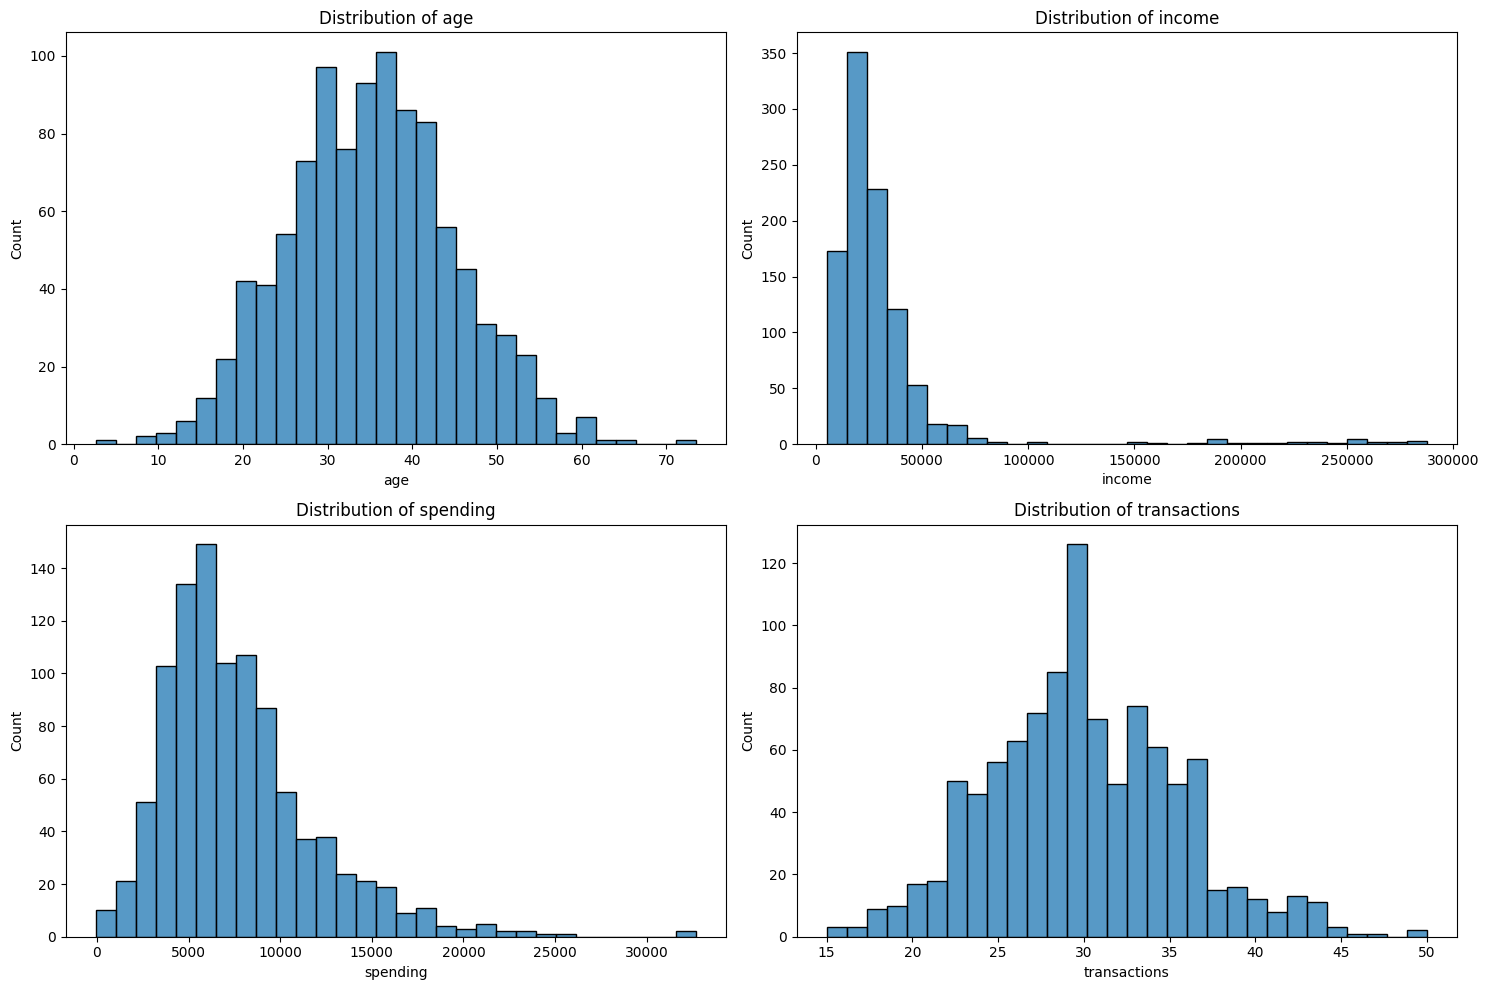

In [11]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['age', 'income', 'spending', 'transactions']):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=feature, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

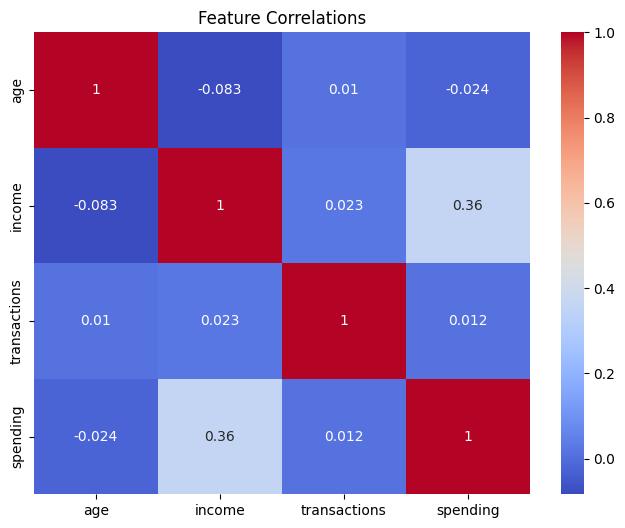

In [12]:
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

# **5. Data Preprocessing**
    Preprocess the data:
    1. Check for missing values
    2. Scale the features

In [13]:
def preprocess_data(df):
    # Create a copy
    df_processed = df.copy()
    
    # Check for missing values
    print("Missing Values:")
    print(df_processed.isnull().sum())
    
    # Scale the features
    scaler = StandardScaler()
    features = ['age', 'income', 'spending', 'transactions']
    df_processed[features] = scaler.fit_transform(df_processed[features])
    
    return df_processed, scaler

In [14]:
df_processed, scaler = preprocess_data(df)

Missing Values:
age             0
income          0
transactions    0
spending        0
dtype: int64


In [15]:
print("\nFirst few rows after preprocessing:")
print(df_processed.head())


First few rows after preprocessing:
        age    income  transactions  spending
0  0.492827  0.343226     -0.339829  1.264485
1 -0.153591  0.090371     -0.521168  0.285375
2  0.646521 -0.241029      0.022849 -0.275522
3  1.537632 -0.423307     -1.790540 -0.779967
4 -0.251208  6.144537      0.929543  0.633435


# **5. Visualization After Data Preprocessing and Scaling**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

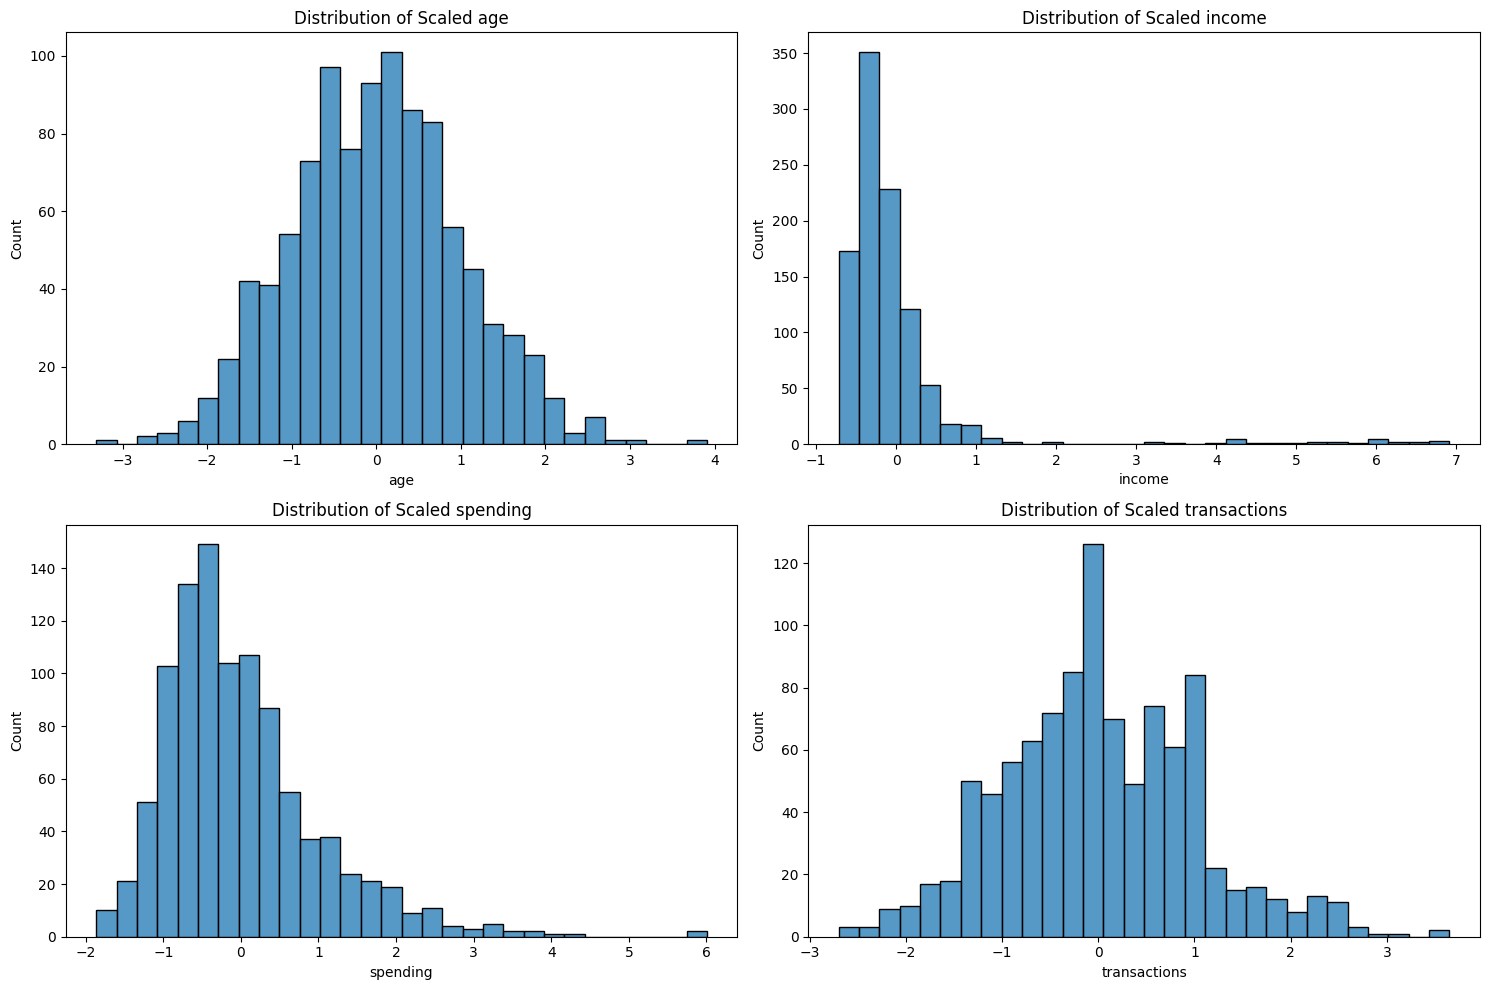

In [16]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['age', 'income', 'spending', 'transactions']):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df_processed, x=feature, bins=30)
    plt.title(f'Distribution of Scaled {feature}')
plt.tight_layout()
plt.show()

# **6. Z-score Based Outlier Detection**
**Description:**
- The Z-score measures how many standard deviations away a data point is from the mean
- Assumes data is normally distributed
- Points with absolute Z-scores above a threshold (typically 3) are considered outliers

**Formula:**
Z = (X - μ) / σ
where:
- X is the data point
- μ is the mean of the dataset
- σ is the standard deviation
- Outlier if |Z| > threshold (typically 3)

**Advantages:**
- Simple to understand and implement
- Works well for normally distributed data
- Computationally efficient

**Disadvantages:**
- Assumes normal distribution
- Sensitive to extreme values
- Not suitable for multivariate detection

**Implementation Notes:**
  1. Calculate mean (μ) and standard deviation (σ) of the dataset
  2. Calculate Z-score for each point using (X - μ) / σ
  3. Take absolute values of Z-scores
  4. Flag points where |Z| > threshold as outliers

In [17]:
def zscore_detection(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    outliers = (z_scores > threshold).any(axis=1)
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns):
        plt.subplot(2, 2, i+1)
        plt.scatter(range(len(data)), 
                   df[column],
                   c=['red' if x else 'blue' for x in outliers],
                   alpha=0.5)
        plt.title(f'Z-score Outliers - {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    
    return outliers

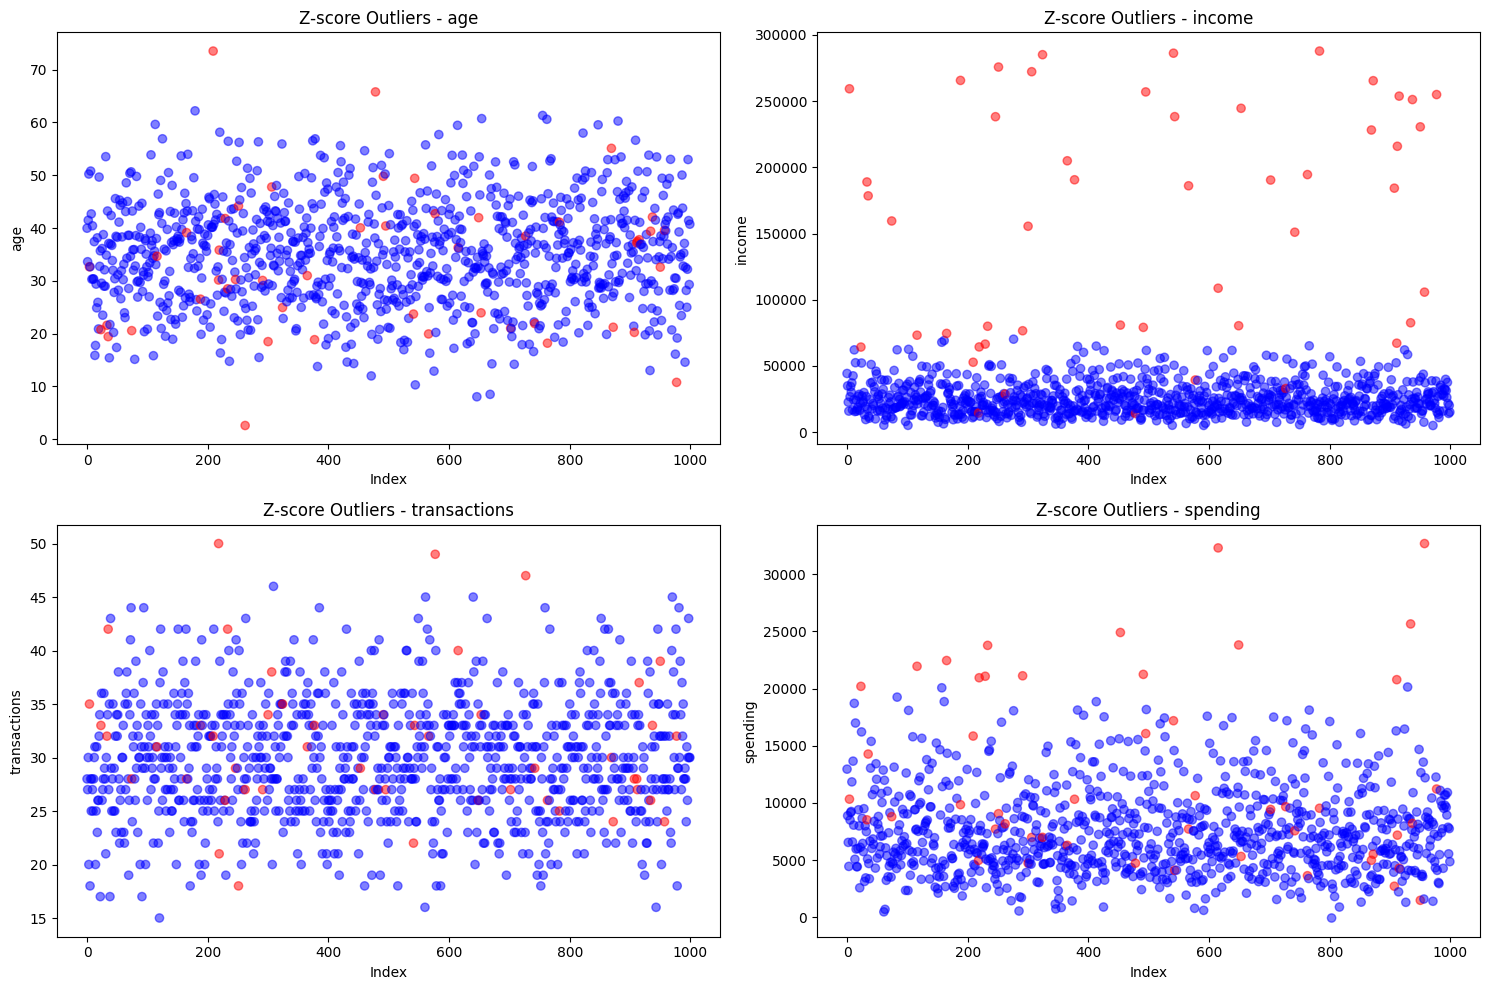

Number of outliers detected by Z-score: 49


In [19]:
zscore_outliers = zscore_detection(df_processed)
print(f"Number of outliers detected by Z-score: {sum(zscore_outliers)}")

# **7. Mahalanobis Distance Based Outlier Detection**
**Description:**
- Measures the distance between a point and the centroid of the distribution
- Accounts for the covariance structure of the data
- Generalizes Z-score to multiple dimensions

**Formula:**
MD = √[(x - μ)ᵀ Σ⁻¹ (x - μ)]
where:
- x is the data point vector
- μ is the mean vector
- Σ is the covariance matrix
- Σ⁻¹ is the inverse covariance matrix
- Outlier if MD > √(χ²(p, α))  where p is dimensions and α is significance level

**Advantages:**
- Considers correlation between features
- Effective for multivariate data
- Scale-invariant

**Disadvantages:**
- Assumes multivariate normal distribution
- Computationally expensive for large datasets
- Sensitive to sample size
"""

**Implementation Notes:**
  1. Calculate mean vector and covariance matrix
  2. Calculate inverse of covariance matrix
  3. Compute Mahalanobis distance for each point
  4. Compare with chi-square threshold

In [24]:
def mahalanobis_detection(data):
    cov = EmpiricalCovariance().fit(data)
    
    # Calculate Mahalanobis distances
    m_dist = cov.mahalanobis(data)
    
    # Calculate threshold based on chi-square distribution
    threshold = chi2.ppf(0.975, df=data.shape[1])
    outliers = m_dist > threshold
    
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns):
        plt.subplot(2, 2, i+1)
        plt.scatter(range(len(data)), 
                   df[column],
                   c=['red' if x else 'blue' for x in outliers],
                   alpha=0.5)
        plt.title(f'Mahalanobis Distance Outliers - {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    
    # Plot Mahalanobis distances
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(data)), m_dist, 
               c=['red' if x else 'blue' for x in outliers],
               alpha=0.5)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Mahalanobis Distances')
    plt.xlabel('Index')
    plt.ylabel('Mahalanobis Distance')
    plt.legend()
    plt.show()
    
    return outliers

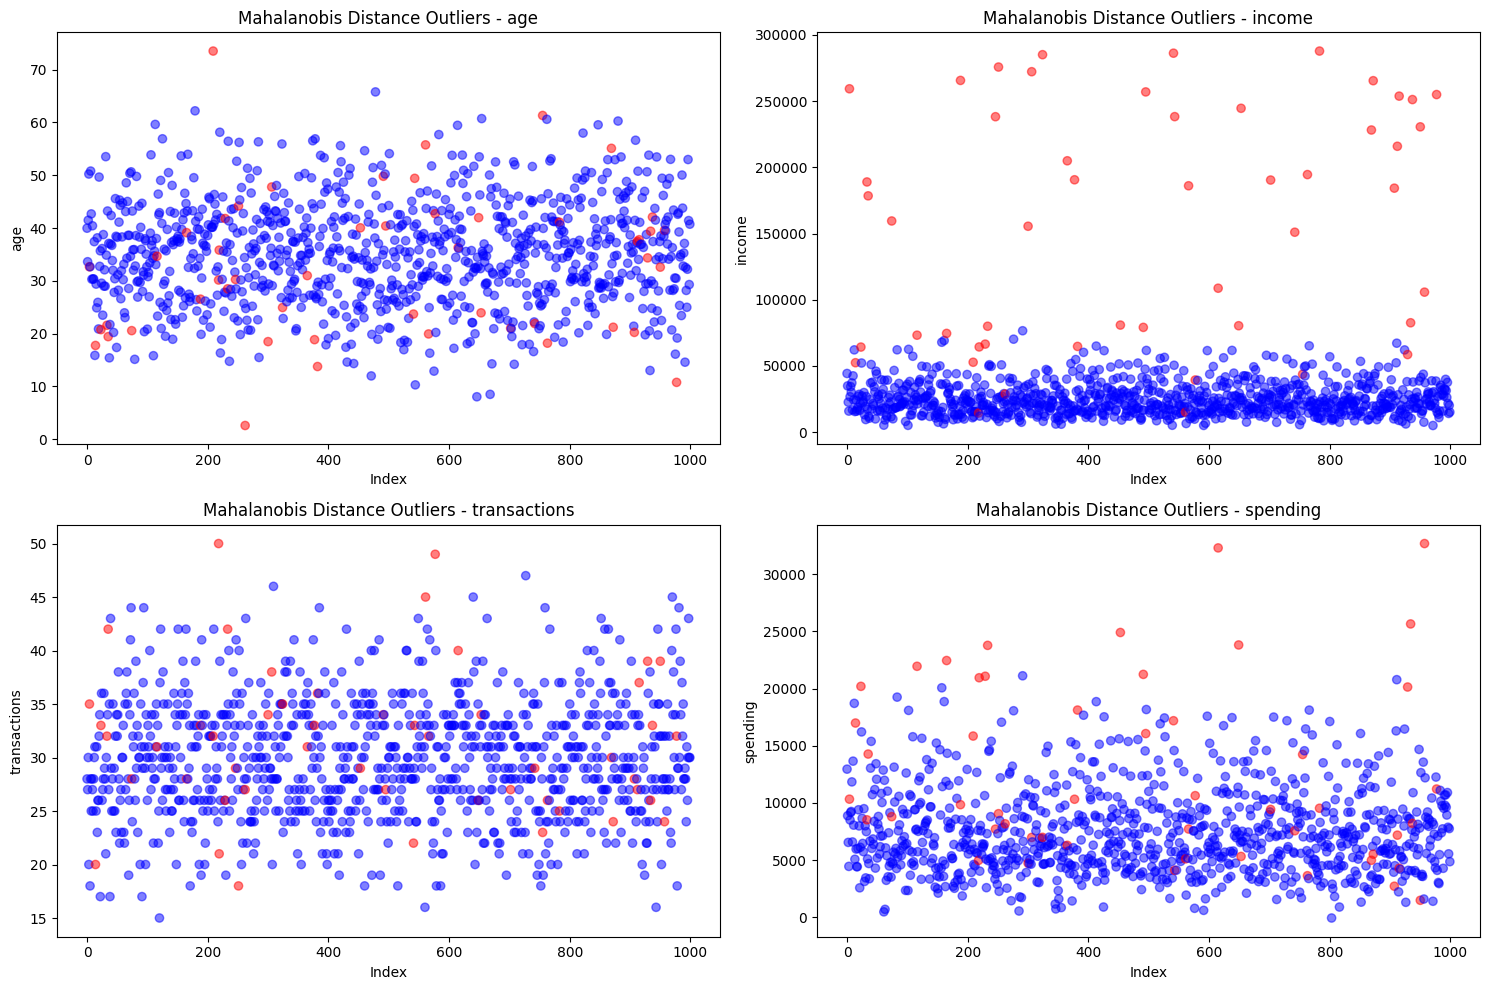

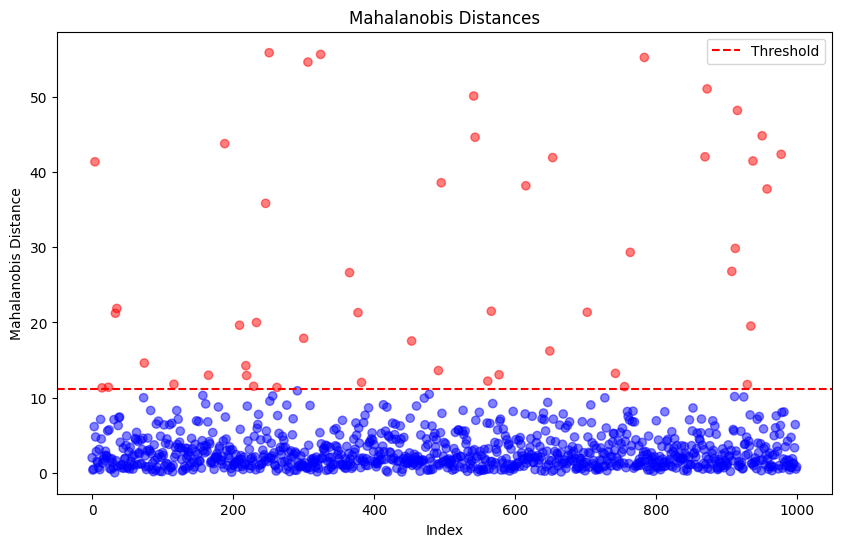

Number of outliers detected by Mahalanobis Distance: 50


In [25]:
mahalanobis_outliers = mahalanobis_detection(df_processed)
print(f"Number of outliers detected by Mahalanobis Distance: {sum(mahalanobis_outliers)}")

# **8. Local Outlier Factor (LOF)**

**Description:**
- Measures the local deviation of density of a point compared to its neighbors
- Identifies local outliers in datasets with varying densities
- Compares the local density of a point to the local densities of its neighbors

**Formula:**
LOF_k(p) = avg[lrd_k(n)/lrd_k(p) for n in N_k(p)]
where:
- k is the number of neighbors
- lrd_k(p) is the local reachability density
- N_k(p) is the k-nearest neighborhood of point p

Local Reachability Density (lrd):
lrd_k(p) = 1 / (avg[reach_dist_k(p,o) for o in N_k(p)])

**Advantages:**
- Works well with varying densities
- Identifies local outliers
- No distribution assumptions

**Disadvantages:**
- Sensitive to k parameter choice
- Computationally intensive
- Can be difficult to interpret
"""

**Implementation Notes:**
 1. Compute k-nearest neighbors for each point
 2. Calculate reachability distances
 3. Compute local reachability density
 4. Calculate LOF scores

In [26]:
def lof_detection(data, contamination=0.1):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    outliers = lof.fit_predict(data) == -1
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns):
        plt.subplot(2, 2, i+1)
        plt.scatter(range(len(data)), 
                   df[column],
                   c=['red' if x else 'blue' for x in outliers],
                   alpha=0.5)
        plt.title(f'LOF Outliers - {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    
    return outliers

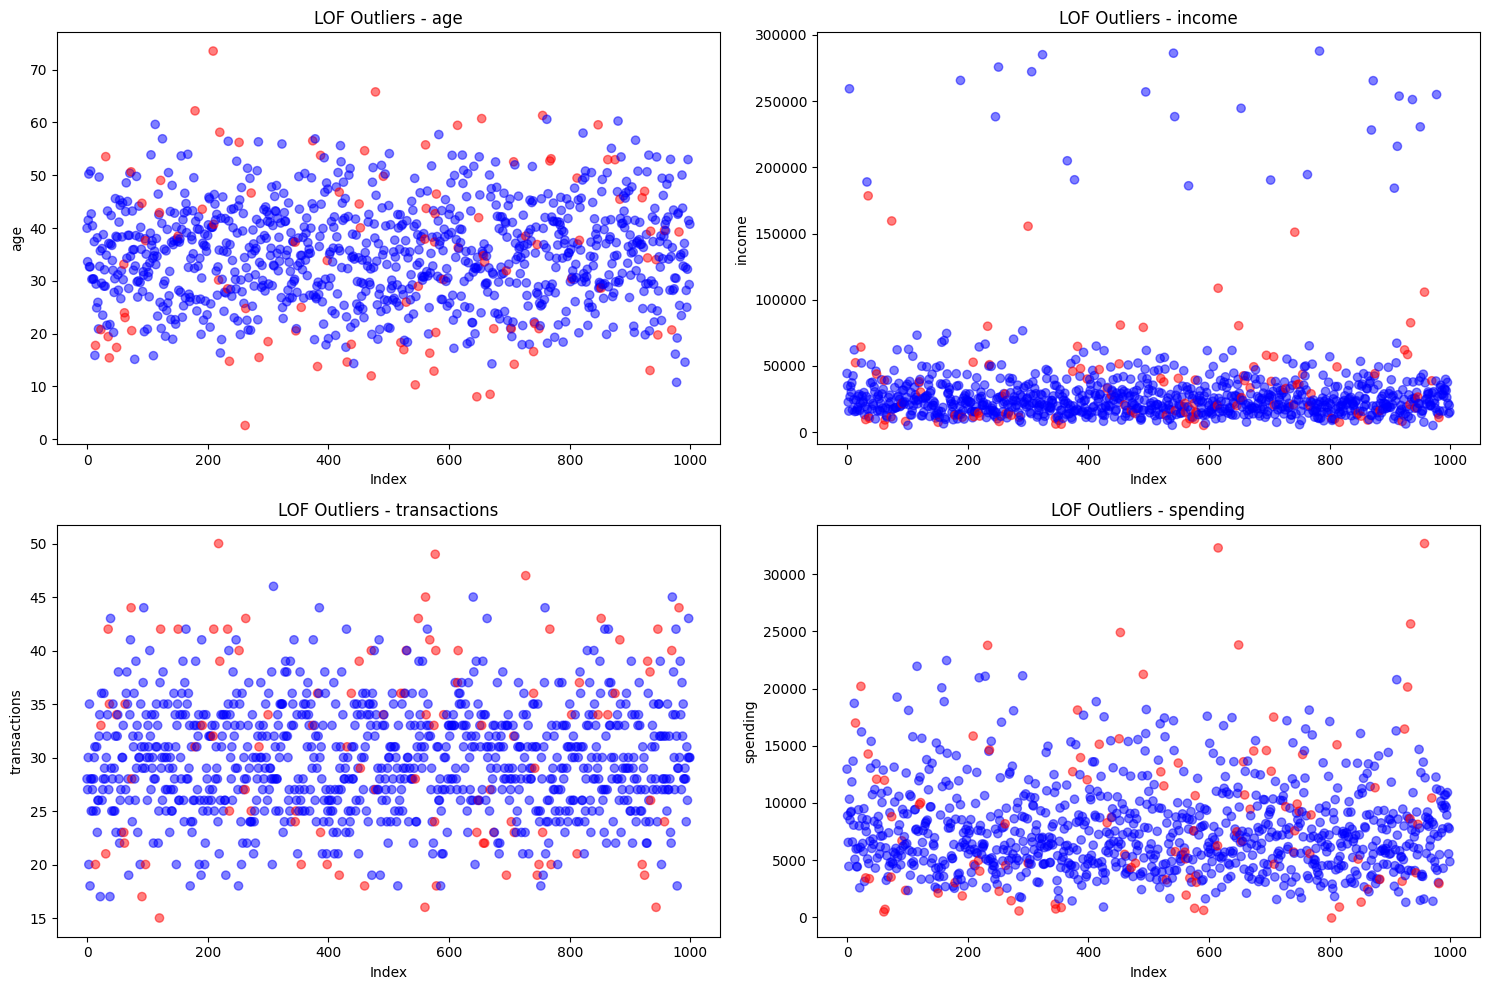

Number of outliers detected by LOF: 100


In [28]:
lof_outliers = lof_detection(df_processed)
print(f"Number of outliers detected by LOF: {sum(lof_outliers)}")

# **9. Isolation Forest**
**Description:**
- Based on the principle that outliers are easier to isolate
- Builds isolation trees by randomly selecting features and split points
- Points with shorter average path lengths are likely outliers

**Formula:**
Anomaly Score = 2^(-E(h(x))/c(n))
where:
- h(x) is the path length for point x
- E(h(x)) is the average path length across trees
- c(n) is the average path length of unsuccessful search in BST
- c(n) = 2H(n-1) - (2(n-1)/n), where H(i) is the harmonic number

**Advantages:**
- Handles high-dimensional data well
- Computationally efficient
- No distance or density calculations needed

**Disadvantages:**
- Random nature can lead to inconsistent results
- May not work well with very small datasets
- Performance depends on forest size


**Implementation Notes:**
  1. Create multiple isolation trees
  2. For each point, compute path length in each tree
  3. Average path lengths across trees
  4. Calculate anomaly scores

In [1]:
def isolation_forest_detection(data, contamination=0.1):
    iso = IsolationForest(contamination=contamination, random_state=42)
    outliers = iso.fit_predict(data) == -1
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns):
        plt.subplot(2, 2, i+1)
        plt.scatter(range(len(data)), 
                   df[column],
                   c=['red' if x else 'blue' for x in outliers],
                   alpha=0.5)
        plt.title(f'Isolation Forest Outliers - {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    
    return outliers

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


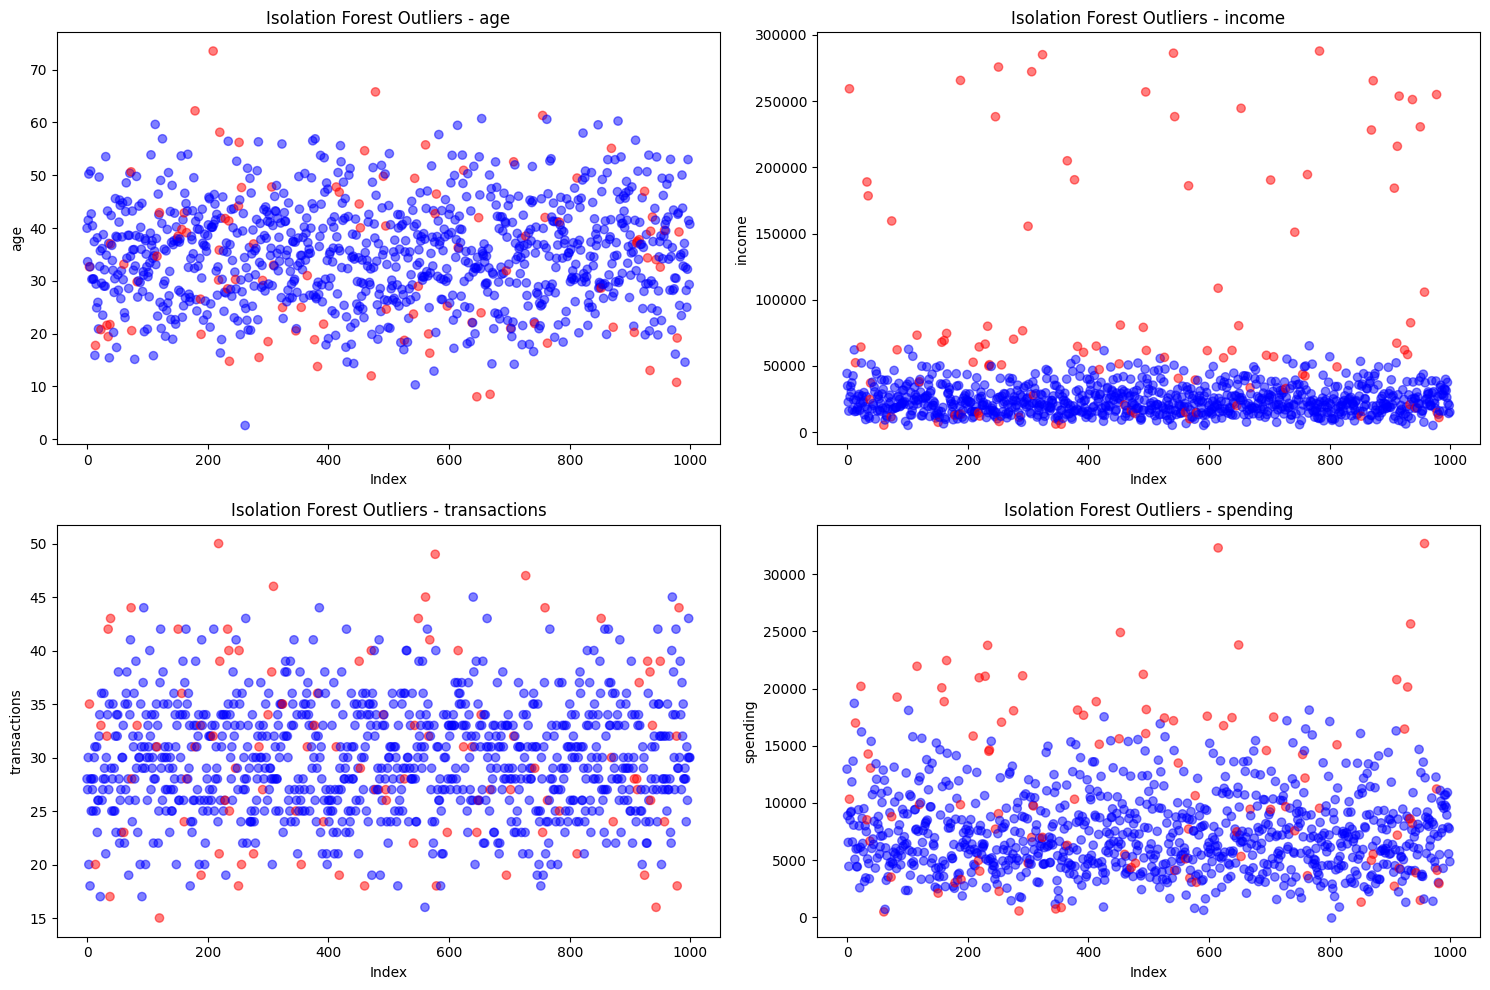

Number of outliers detected by Isolation Forest: 100


In [31]:
# Apply Isolation Forest detection
iforest_outliers = isolation_forest_detection(df_processed)
print(f"Number of outliers detected by Isolation Forest: {sum(iforest_outliers)}")

# **10. One-Class SVM**

**Description:**
- Learns a decision boundary that encompasses the normal data
- Maps data to high-dimensional space using kernel function
- Points outside the boundary are considered outliers

**Formula:**
Optimization Problem:
min 1/(2||w||²) + 1/(νn)Σξᵢ - ρ
subject to:
(w·Φ(xᵢ)) ≥ ρ - ξᵢ
ξᵢ ≥ 0

**where:**
- w is the normal vector to the hyperplane
- Φ is the kernel function
- ν is the upper bound on the fraction of outliers
- ξᵢ are slack variables
- ρ is the offset

**Advantages:**
- Works well with non-linear data
- No distribution assumptions
- Robust to noise

**Disadvantages:**
- Sensitive to kernel and parameter choice
- Computationally expensive
- Can be difficult to tune parameters

**Implementation Notes:**
  1. Choose appropriate kernel function
  2. Set parameters (nu, gamma)
  3. Train model on normal data
  4. Use decision function to identify outliers

In [32]:
def ocsvm_detection(data, nu=0.1):
    ocsvm = OneClassSVM(kernel='rbf', nu=nu)
    outliers = ocsvm.fit_predict(data) == -1
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns):
        plt.subplot(2, 2, i+1)
        plt.scatter(range(len(data)), 
                   df[column],
                   c=['red' if x else 'blue' for x in outliers],
                   alpha=0.5)
        plt.title(f'One-Class SVM Outliers - {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    
    return outliers

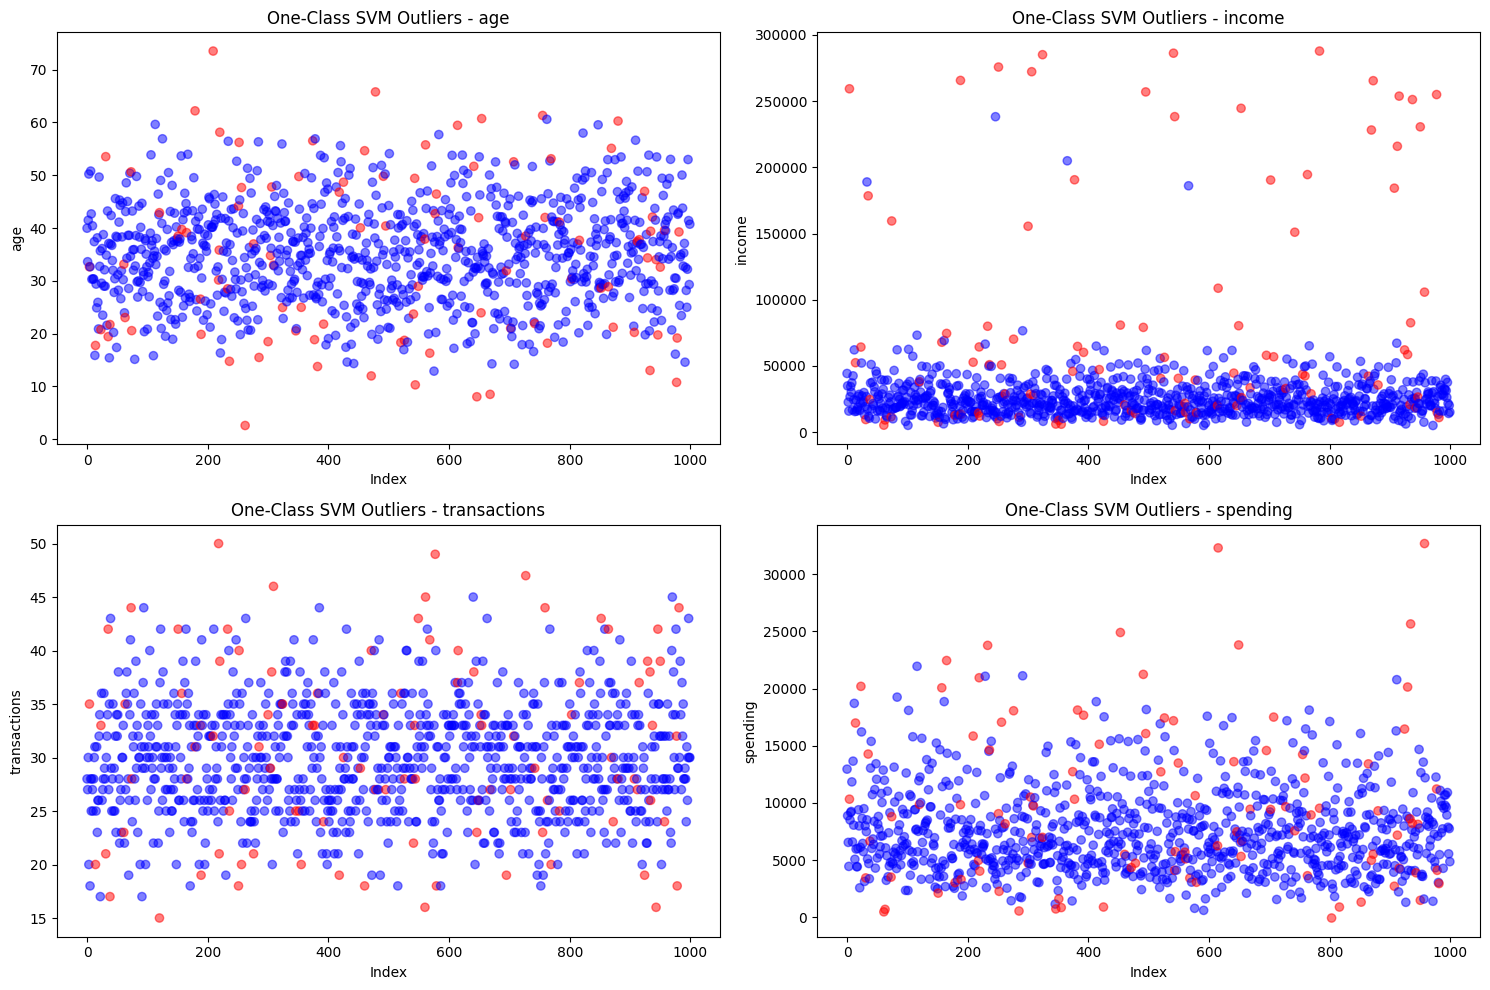

Number of outliers detected by One-Class SVM: 100


In [34]:
ocsvm_outliers = ocsvm_detection(df_processed)
print(f"Number of outliers detected by One-Class SVM: {sum(ocsvm_outliers)}")

# **11. Comparing all the Methods**

In [35]:
methods_results = {
    'Z-score': zscore_outliers,
    'Mahalanobis': mahalanobis_outliers,
    'LOF': lof_outliers,
    'Isolation Forest': iforest_outliers,
    'One-Class SVM': ocsvm_outliers
}

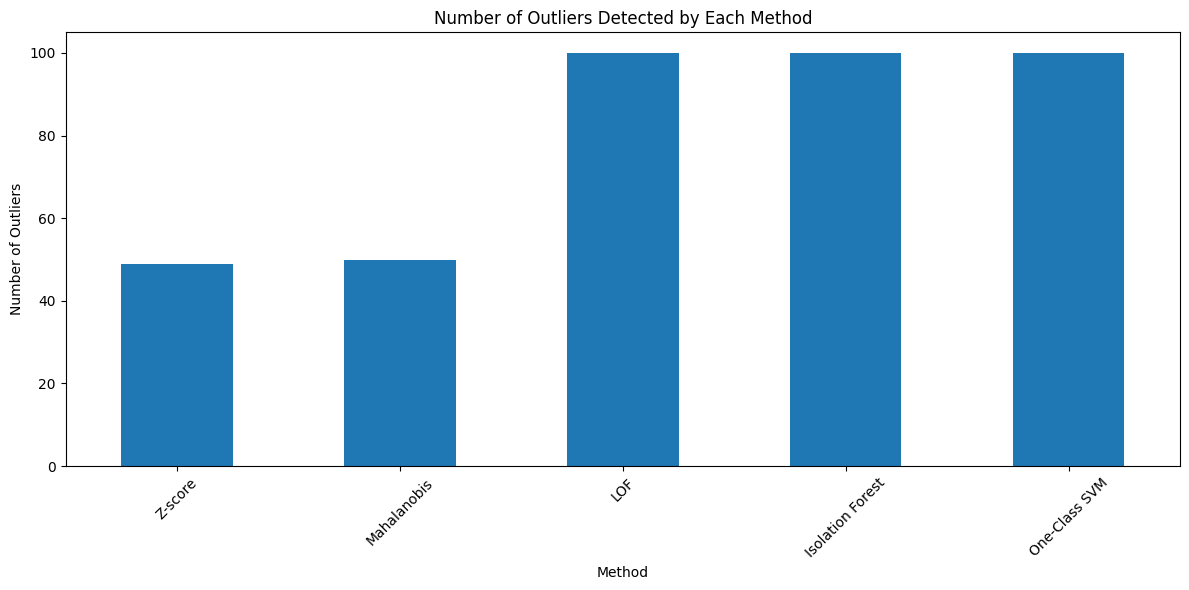

In [36]:
plt.figure(figsize=(12, 6))
outlier_counts = pd.Series({method: sum(outliers) for method, outliers in methods_results.items()})
outlier_counts.plot(kind='bar')
plt.title('Number of Outliers Detected by Each Method')
plt.xlabel('Method')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
methods = list(methods_results.keys())
n_methods = len(methods)
agreement_matrix = np.zeros((n_methods, n_methods))

for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        agreement = np.mean(methods_results[method1] == methods_results[method2])
        agreement_matrix[i, j] = agreement


In [41]:
agreement_df = pd.DataFrame(
    agreement_matrix,
    index=methods,
    columns=methods
)

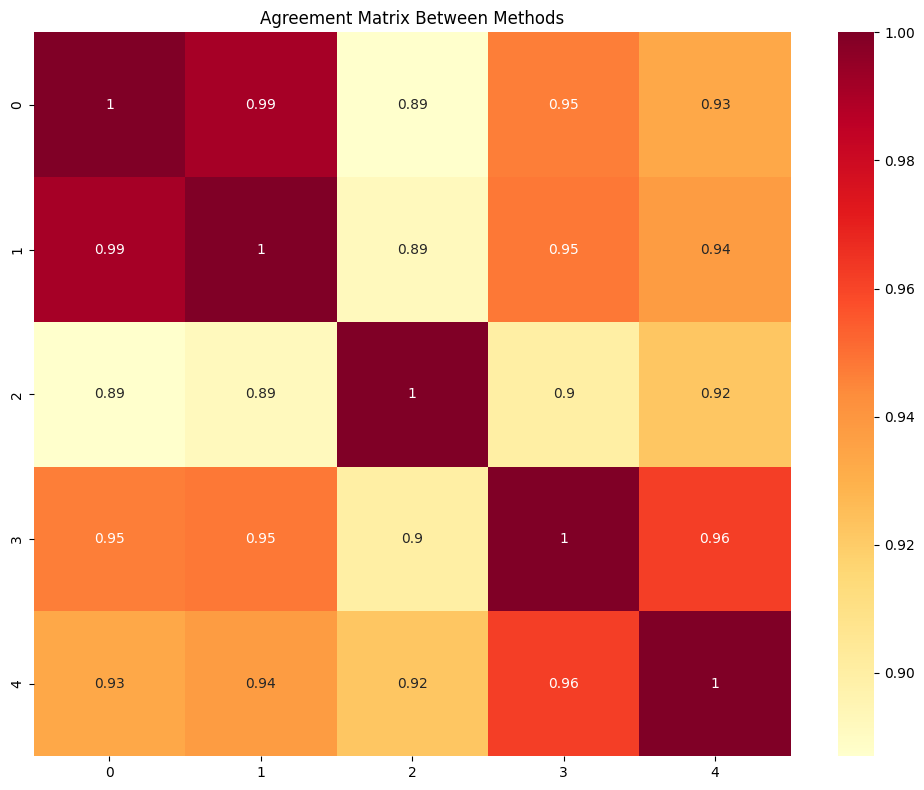

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap='YlOrRd')
plt.title('Agreement Matrix Between Methods')
plt.tight_layout()
plt.show()

# **Summery of all the methods**

In [50]:
def generate_summary_report(methods_results, df):
    report = """
    Outlier Detection Analysis Report
    ===============================
    Dataset Overview:
    ----------------
    - Number of samples: {n_samples}
    - Number of features: {n_features}
    - Features: {features}
    
    Method Comparison:
    ----------------
    """.format(
        n_samples=len(df),
        n_features=len(df.columns),
        features=", ".join(df.columns)
    )
    
    for method, outliers in methods_results.items():
        report += f"\n{method}:"
        report += f"\n- Number of outliers detected: {sum(outliers)}"
        report += f"\n- Percentage of outliers: {(sum(outliers)/len(outliers))*100:.2f}%\n"
    
    return report

In [51]:
summary_report = generate_summary_report(methods_results, df)
print(summary_report)


    Outlier Detection Analysis Report
    Dataset Overview:
    ----------------
    - Number of samples: 1000
    - Number of features: 4
    - Features: age, income, transactions, spending
    
    Method Comparison:
    ----------------
    
Z-score:
- Number of outliers detected: 49
- Percentage of outliers: 4.90%

Mahalanobis:
- Number of outliers detected: 50
- Percentage of outliers: 5.00%

LOF:
- Number of outliers detected: 100
- Percentage of outliers: 10.00%

Isolation Forest:
- Number of outliers detected: 100
- Percentage of outliers: 10.00%

One-Class SVM:
- Number of outliers detected: 100
- Percentage of outliers: 10.00%



# **Comparison of Methods**
-------------------
1. Z-score:
   - Best for: Single-variable, normally distributed data
   - Use when: Quick, simple analysis needed
   - Computational complexity: O(n)

2. Mahalanobis Distance:
   - Best for: Multivariate, correlated data
   - Use when: Feature correlations are important
   - Computational complexity: O(n²)

3. LOF:
   - Best for: Data with varying densities
   - Use when: Local outliers are important
   - Computational complexity: O(n² log n)

4. Isolation Forest:
   - Best for: High-dimensional data
   - Use when: Scalability is important
   - Computational complexity: O(n log n)

5. One-Class SVM:
   - Best for: Complex, non-linear data
   - Use when: Clear decision boundary needed
   - Computational complexity: O(n² log n)

Selection Criteria:
- Data dimensionality
- Data distribution
- Computational resources
- Interpretability needs
- Local vs global outliers
"""